In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
import seaborn as sns
import anndata

from scroutines import basicu
from scroutines.config_plots import *
import importlib
importlib.reload(basicu)

<module 'scroutines.basicu' from '/scr/qlyu/projects/v1/scroutines/scroutines/basicu.py'>

In [2]:
sns.set_context('talk')

# get data

In [3]:
ddir = '../data/cheng21_cell_scrna/organized/'
files = [
    'P8NR.h5ad',
    'P14NR.h5ad',
    'P17NR.h5ad',
    'P21NR.h5ad',
    'P28NR.h5ad',
    'P38NR.h5ad',
    
    'P28DR.h5ad',
    'P38DR.h5ad',
    
    'P28DL.h5ad',
] 

In [4]:
conds = np.array([f.replace('.h5ad', '') for f in files])
conds

array(['P8NR', 'P14NR', 'P17NR', 'P21NR', 'P28NR', 'P38NR', 'P28DR',
       'P38DR', 'P28DL'], dtype='<U5')

In [5]:
pbulks = []
xclsts = []
xcnsts = []

# ncond, nrep, nclst, ngene = 3,4,20,-1
ncond, nrep, nclst, ngene = len(files), 2,20,-1

for f in files:
    print(f)
    
    path = os.path.join(ddir, f)
    adata = anndata.read(path)
    genes = adata.var.index.values
    
    mat = adata.X
    types = adata.obs['Subclass'].astype(str).values 
    # 1 or 2
    sample_codes = adata.obs['sample'].apply(lambda x: x.split('_')[-1][:-1].replace('3', '2')).astype(str).values
    # sample_codes = adata.obs['sample'].apply(lambda x: x.split('_')[-1].replace('3', '2')).astype(str).values
    sample_and_type = sample_codes + "_" + types
    unqs, cnts = np.unique(sample_and_type, return_counts=True)
    _xclsts, Xk, Xk_n, Xk_ln = basicu.counts_to_bulk_profiles(mat, sample_and_type) 
    
    # check all types + reps are the same
    if len(xclsts) > 0:
        if not np.all(_xclsts == xclsts):
            raise ValueError(_xclsts.shape, xclsts.shape, _xclsts, xclsts,)
        if not np.all(_xclsts == unqs):
            raise ValueError(_xclsts.shape, unqs.shape, _xclsts, unqs,)
    else:
        xclsts = _xclsts
        print(xclsts)
        
    print(Xk_ln.shape)
    pbulks.append(Xk_ln)
    xcnsts.append(cnts)
    
pbulks = np.array(pbulks)
xcnsts = np.array(xcnsts)
print(pbulks.shape)
pbulks = pbulks.reshape(ncond,nrep,nclst,-1)
xcnsts = xcnsts.reshape(ncond,nrep,nclst)
xclsts = xclsts.reshape(      nrep,nclst)
print(pbulks.shape)

P8NR.h5ad
['1_Astro' '1_Endo' '1_Frem1' '1_L2/3' '1_L4' '1_L5IT' '1_L5NP' '1_L5PT'
 '1_L6CT' '1_L6IT' '1_L6b' '1_Lamp5' '1_Micro' '1_OD' '1_OPC' '1_Pvalb'
 '1_Sst' '1_Stac' '1_VLMC' '1_Vip' '2_Astro' '2_Endo' '2_Frem1' '2_L2/3'
 '2_L4' '2_L5IT' '2_L5NP' '2_L5PT' '2_L6CT' '2_L6IT' '2_L6b' '2_Lamp5'
 '2_Micro' '2_OD' '2_OPC' '2_Pvalb' '2_Sst' '2_Stac' '2_VLMC' '2_Vip']
(40, 53801)
P14NR.h5ad
(40, 53801)
P17NR.h5ad
(40, 53801)
P21NR.h5ad
(40, 53801)
P28NR.h5ad
(40, 53801)
P38NR.h5ad
(40, 53801)
P28DR.h5ad
(40, 53801)
P38DR.h5ad
(40, 53801)
P28DL.h5ad
(40, 53801)
(9, 40, 53801)
(9, 2, 20, 53801)


In [6]:
# check the pbulks are good -- log10(CPM+1) for each sample
checkpbulks = np.sum(np.power(10, pbulks)-1, axis=-1)
checkpbulks.shape, np.all(np.abs(checkpbulks-1e6) < 1e-6)

((9, 2, 20), True)

In [7]:
# xclsts_short = np.array([clst[len("1a_"):] for clst in xclsts[0]]) #, '_'
xclsts_short = np.array([clst[len("1_"):] for clst in xclsts[0]]) #, '_'
xclsts_short

array(['Astro', 'Endo', 'Frem1', 'L2/3', 'L4', 'L5IT', 'L5NP', 'L5PT',
       'L6CT', 'L6IT', 'L6b', 'Lamp5', 'Micro', 'OD', 'OPC', 'Pvalb',
       'Sst', 'Stac', 'VLMC', 'Vip'], dtype='<U5')

# filter out small bulk profiles

In [8]:
numcells = pd.DataFrame(xcnsts.T.reshape(-1,nrep*ncond), index=xclsts_short)
numcells

0     1     2     3     4    5     6     7     8     9     10    11  \
Astro   582  1640  1482  1043   921  280   655   974   941   845  1171  1341   
Endo    124   254   449   200   138  112   472   329   205   121   118   148   
Frem1    21    50    40    32    39   11    29    28    47    45    34    28   
L2/3   1002  3687  3029  1929  2071  720  2011  2426  2367  2381  2560  2655   
L4     1081  3382  2424  2043  2429  831  1835  2420  2577  2551  2528  2279   
L5IT    119   599   510   424   386  195   370   427   594   344   454   417   
L5NP     74   319   215   185   153   97   131   171   248   171   203   196   
L5PT    105   522   440   305   345  163   420   454   501   451   456   364   
L6CT    772  2345  1831  1268  1369  305  1138  1494  1611  1594  1609  1524   
L6IT    351  1254   955   725   671  243   662   774   820   788   869   853   
L6b      28   238   126   115    95   46    92   107    93   102   195   122   
Lamp5    48   196   182   100    98   40   102   129   186   131   153   155   
Micro   138   822  1096   835   427  198   538   476   798   124   538   950   
OD       40   626   645   744   614  293   516   793   655    56   423   542   
OPC     364   989   693   653   333  157   252   310   409   579   615   734   
Pvalb   246   581   520   408   349  128   193   467   620   512   436   468   
Sst     123   511   334   322   278  117   228   296   423   344   335   345   
Stac     18    44    34    31    11   14    19    33    45    45    29    34   
VLMC     14   377   328   153    86   29    86    90   158    35   135   207   
Vip      84   276   218   209   160   69   109   160   258   194   199   240   

         12    13    14    15    16    17  
Astro  1484  1247  1205  1305  1110  1136  
Endo    206   287   364   342   114   333  
Frem1    30    60    41    41    25    24  
L2/3   2536  1973  1977  2693  2739  2292  
L4     2674  2303  2308  2776  2954  2386  
L5IT    478   463   506   567   454   485  
L5NP    229   242   214   215   192   233  
L5PT    410   363   437   481   429   410  
L6CT   1678  1546  1501  1870  1534  1587  
L6IT    894   765   849  1022   840   770  
L6b      86   141    93    96    84    78  
Lamp5   128   125   164   196   173   167  
Micro   689   721   574   694   396   626  
OD      753   931  1006   743   764   794  
OPC     750   620   477   462   346   393  
Pvalb   504   440   428   542   507   550  
Sst     357   316   369   443   350   350  
Stac     25    31    32    29    23    34  
VLMC    238   184   198   197   106   198  
Vip     250   199   206   243   169   173

In [9]:
numcells.min(axis=1).sort_values()

Frem1     11
Stac      11
VLMC      14
L6b       28
Lamp5     40
OD        40
Vip       69
L5NP      74
L5PT     105
Endo     112
Sst      117
L5IT     119
Micro    124
Pvalb    128
OPC      157
L6IT     243
Astro    280
L6CT     305
L2/3     720
L4       831
dtype: int64

In [10]:
xclsts_sel = xclsts_short[numcells.min(axis=1)>50]
unq_types = xclsts_sel
xclsts_selidx = basicu.get_index_from_array(xclsts_short, xclsts_sel)
pbulks = pbulks[:,:,xclsts_selidx,:]
xclsts_sel, xclsts_selidx

(array(['Astro', 'Endo', 'L2/3', 'L4', 'L5IT', 'L5NP', 'L5PT', 'L6CT',
        'L6IT', 'Micro', 'OPC', 'Pvalb', 'Sst', 'Vip'], dtype='<U5'),
 array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 12, 14, 15, 16, 19]))

# Check a few genes and see

In [11]:
def plot_one_gene(gene_name, type_name, conds=None, ax=None, palette=None, s=5):
    gidx = basicu.get_index_from_array(genes, [gene_name])[0]
    cidx = basicu.get_index_from_array(unq_types, [type_name])[0]
    mat = pbulks[:,:,cidx,gidx].T

    if ax is None:
        fig, ax = plt.subplots(figsize=(0.5*mat.shape[1],5))
    sns.boxplot  (mat, color='white', linewidth=1, ax=ax)
    sns.swarmplot(mat, s=s, ax=ax, palette=palette)
    if conds is not None:
        ax.set_xticklabels(conds, rotation=90)
    ax.set_ylabel('log10CPM')
    ax.set_title(f'{gene_name} in {type_name}')
    return ax

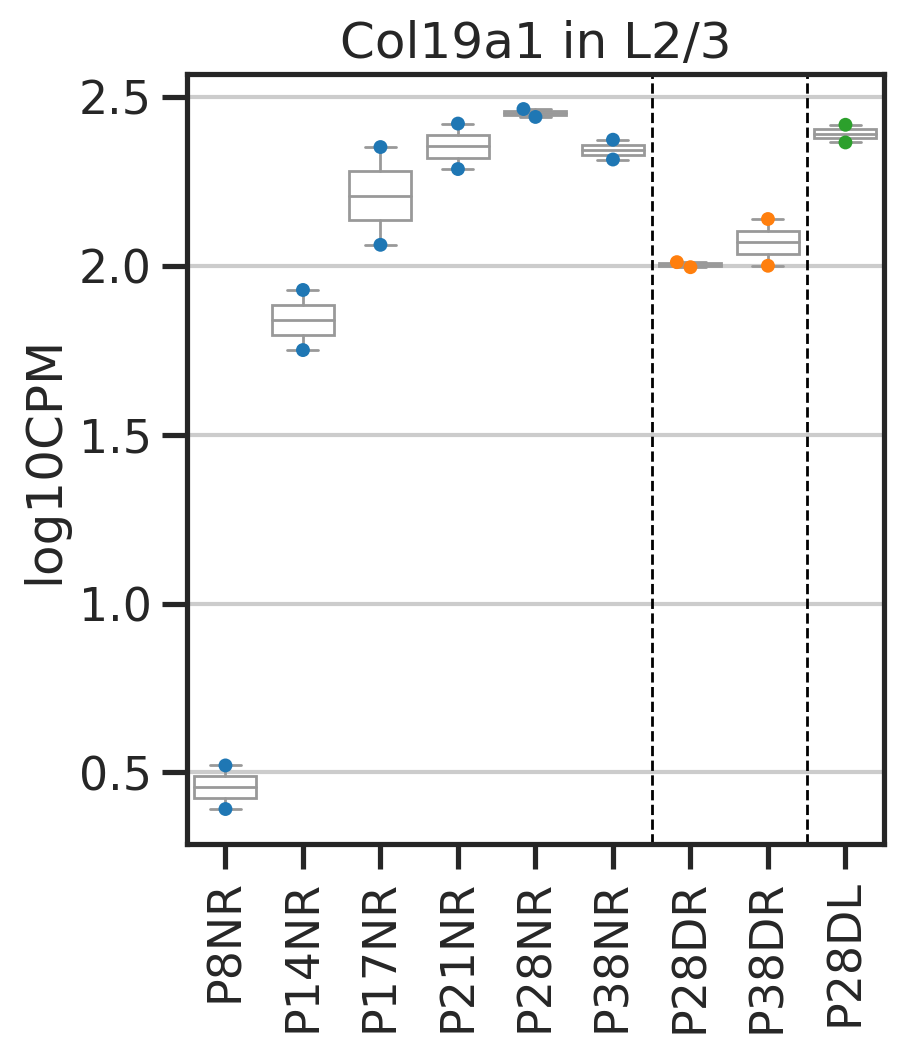

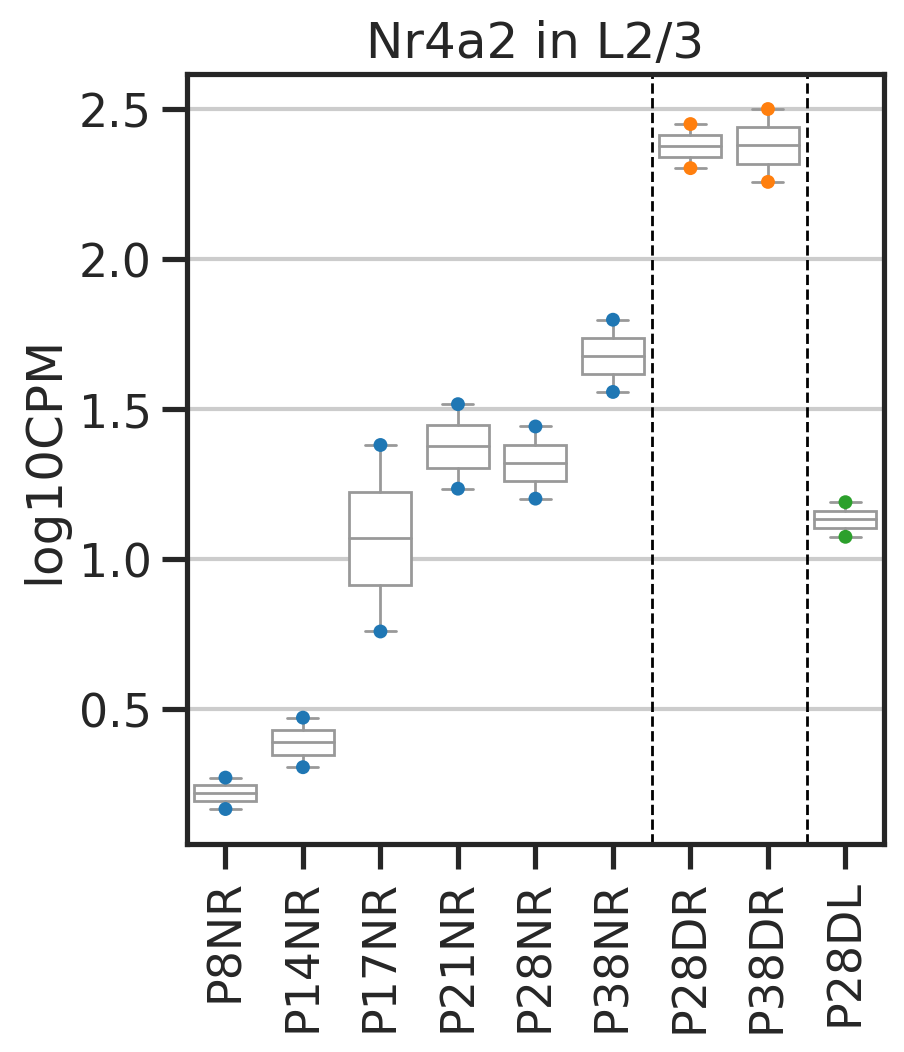

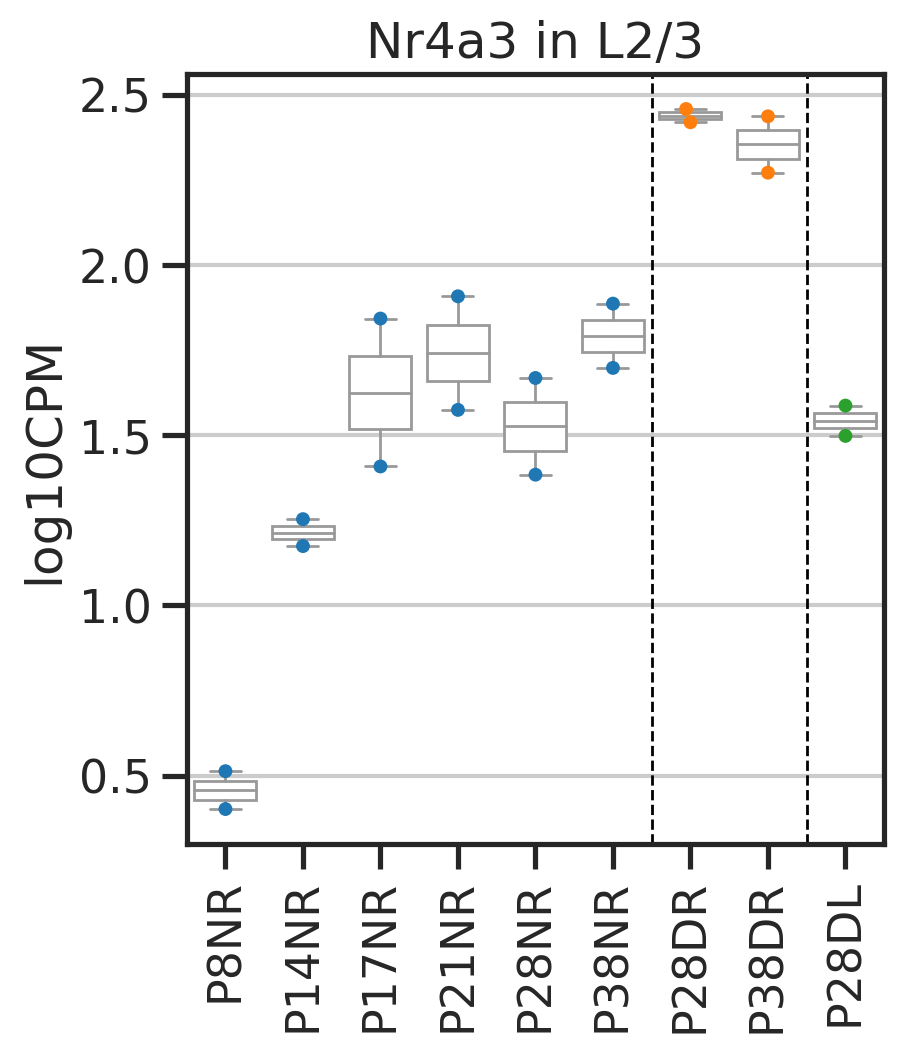

In [12]:
# conds = None #["P28NR", "P28DR", "P38DR"]
conds = conds
palette = ['C0']*6+['C1']*2+['C2']

gene_name = 'Col19a1'
type_name = 'L2/3'
ax = plot_one_gene(gene_name, type_name, conds=conds, palette=palette)
ax.axvline(5.5, linestyle='--', color='k', linewidth=1)
ax.axvline(7.5, linestyle='--', color='k', linewidth=1)

gene_name = 'Nr4a2'
type_name = 'L2/3'
ax = plot_one_gene(gene_name, type_name, conds=conds, palette=palette)
ax.axvline(5.5, linestyle='--', color='k', linewidth=1)
ax.axvline(7.5, linestyle='--', color='k', linewidth=1)

gene_name = 'Nr4a3'
type_name = 'L2/3'
ax = plot_one_gene(gene_name, type_name, conds=conds, palette=palette)
ax.axvline(5.5, linestyle='--', color='k', linewidth=1)
ax.axvline(7.5, linestyle='--', color='k', linewidth=1)

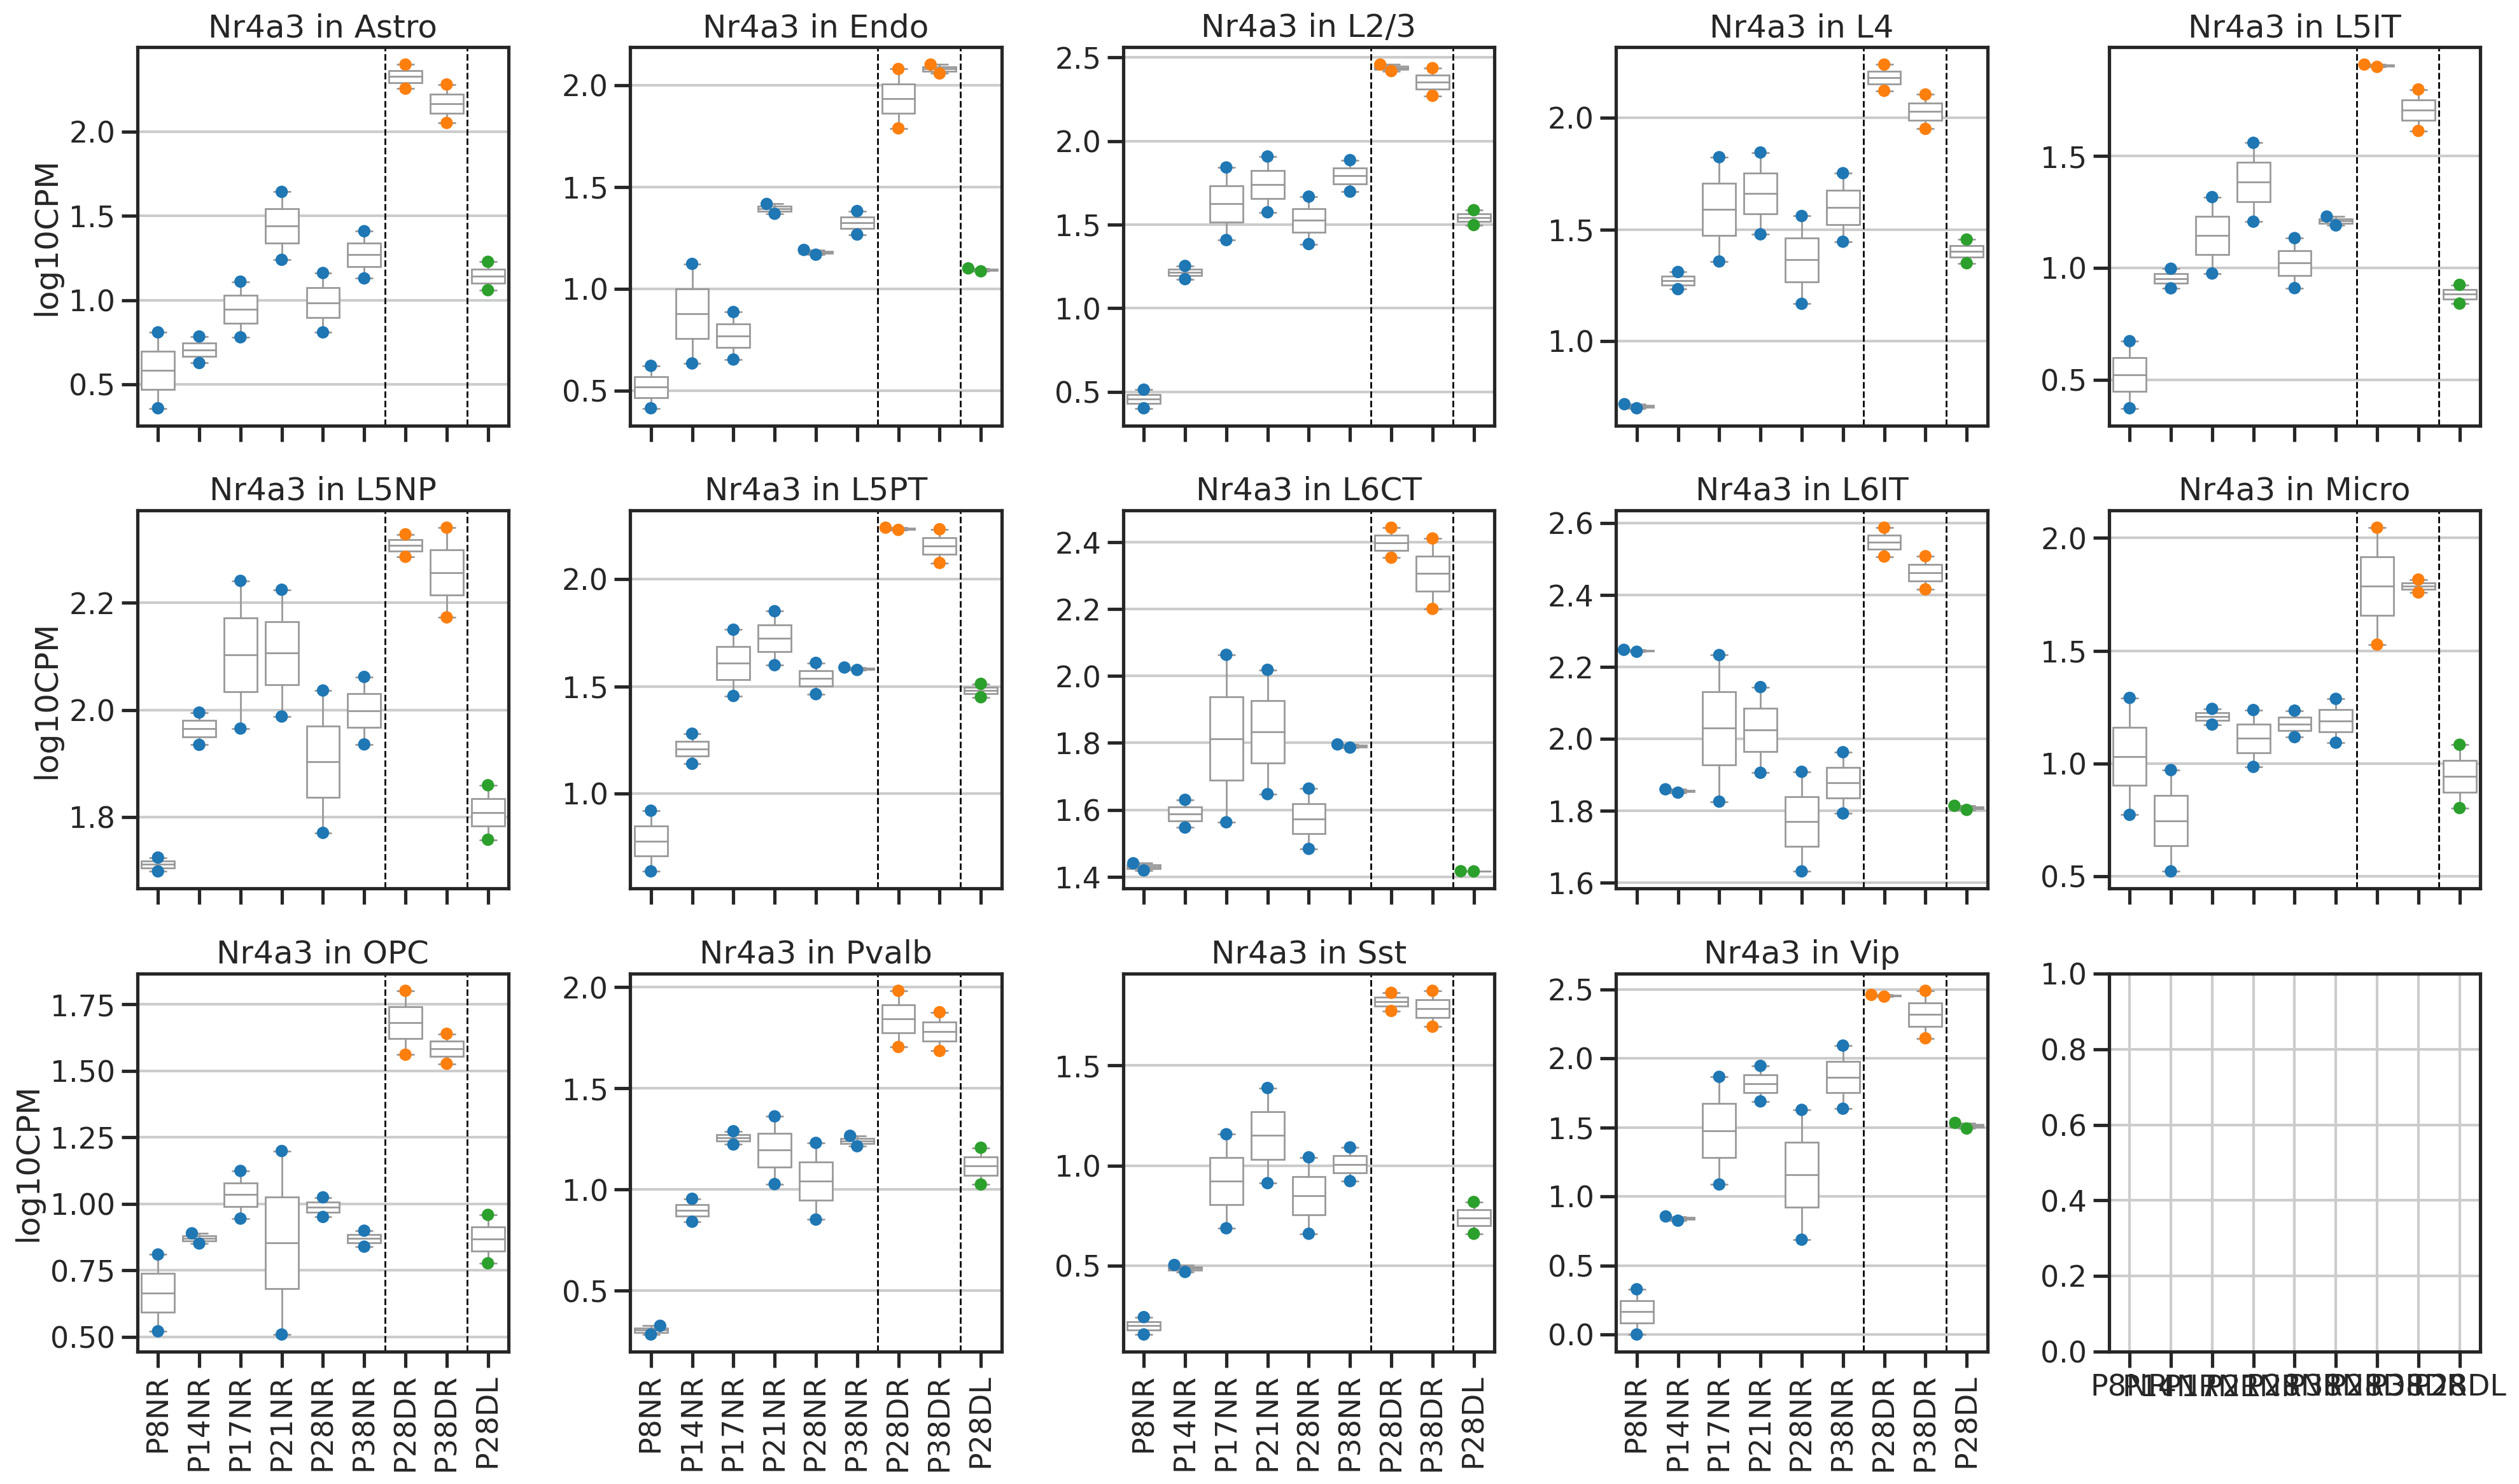

In [13]:
gene_name = 'Nr4a3'
# type_name = 'L2/3'

fig, axs = plt.subplots(3,5,figsize=(5*4,3*4), sharex=True)
for i, type_name in enumerate(unq_types):
    ax = axs.flat[i]
    ax = plot_one_gene(gene_name, type_name, ax=ax, conds=conds, palette=palette, s=7)
    if i%5 != 0:
        ax.set_ylabel('')
    ax.axvline(5.5, linestyle='--', color='k', linewidth=1)
    ax.axvline(7.5, linestyle='--', color='k', linewidth=1)
fig.tight_layout()

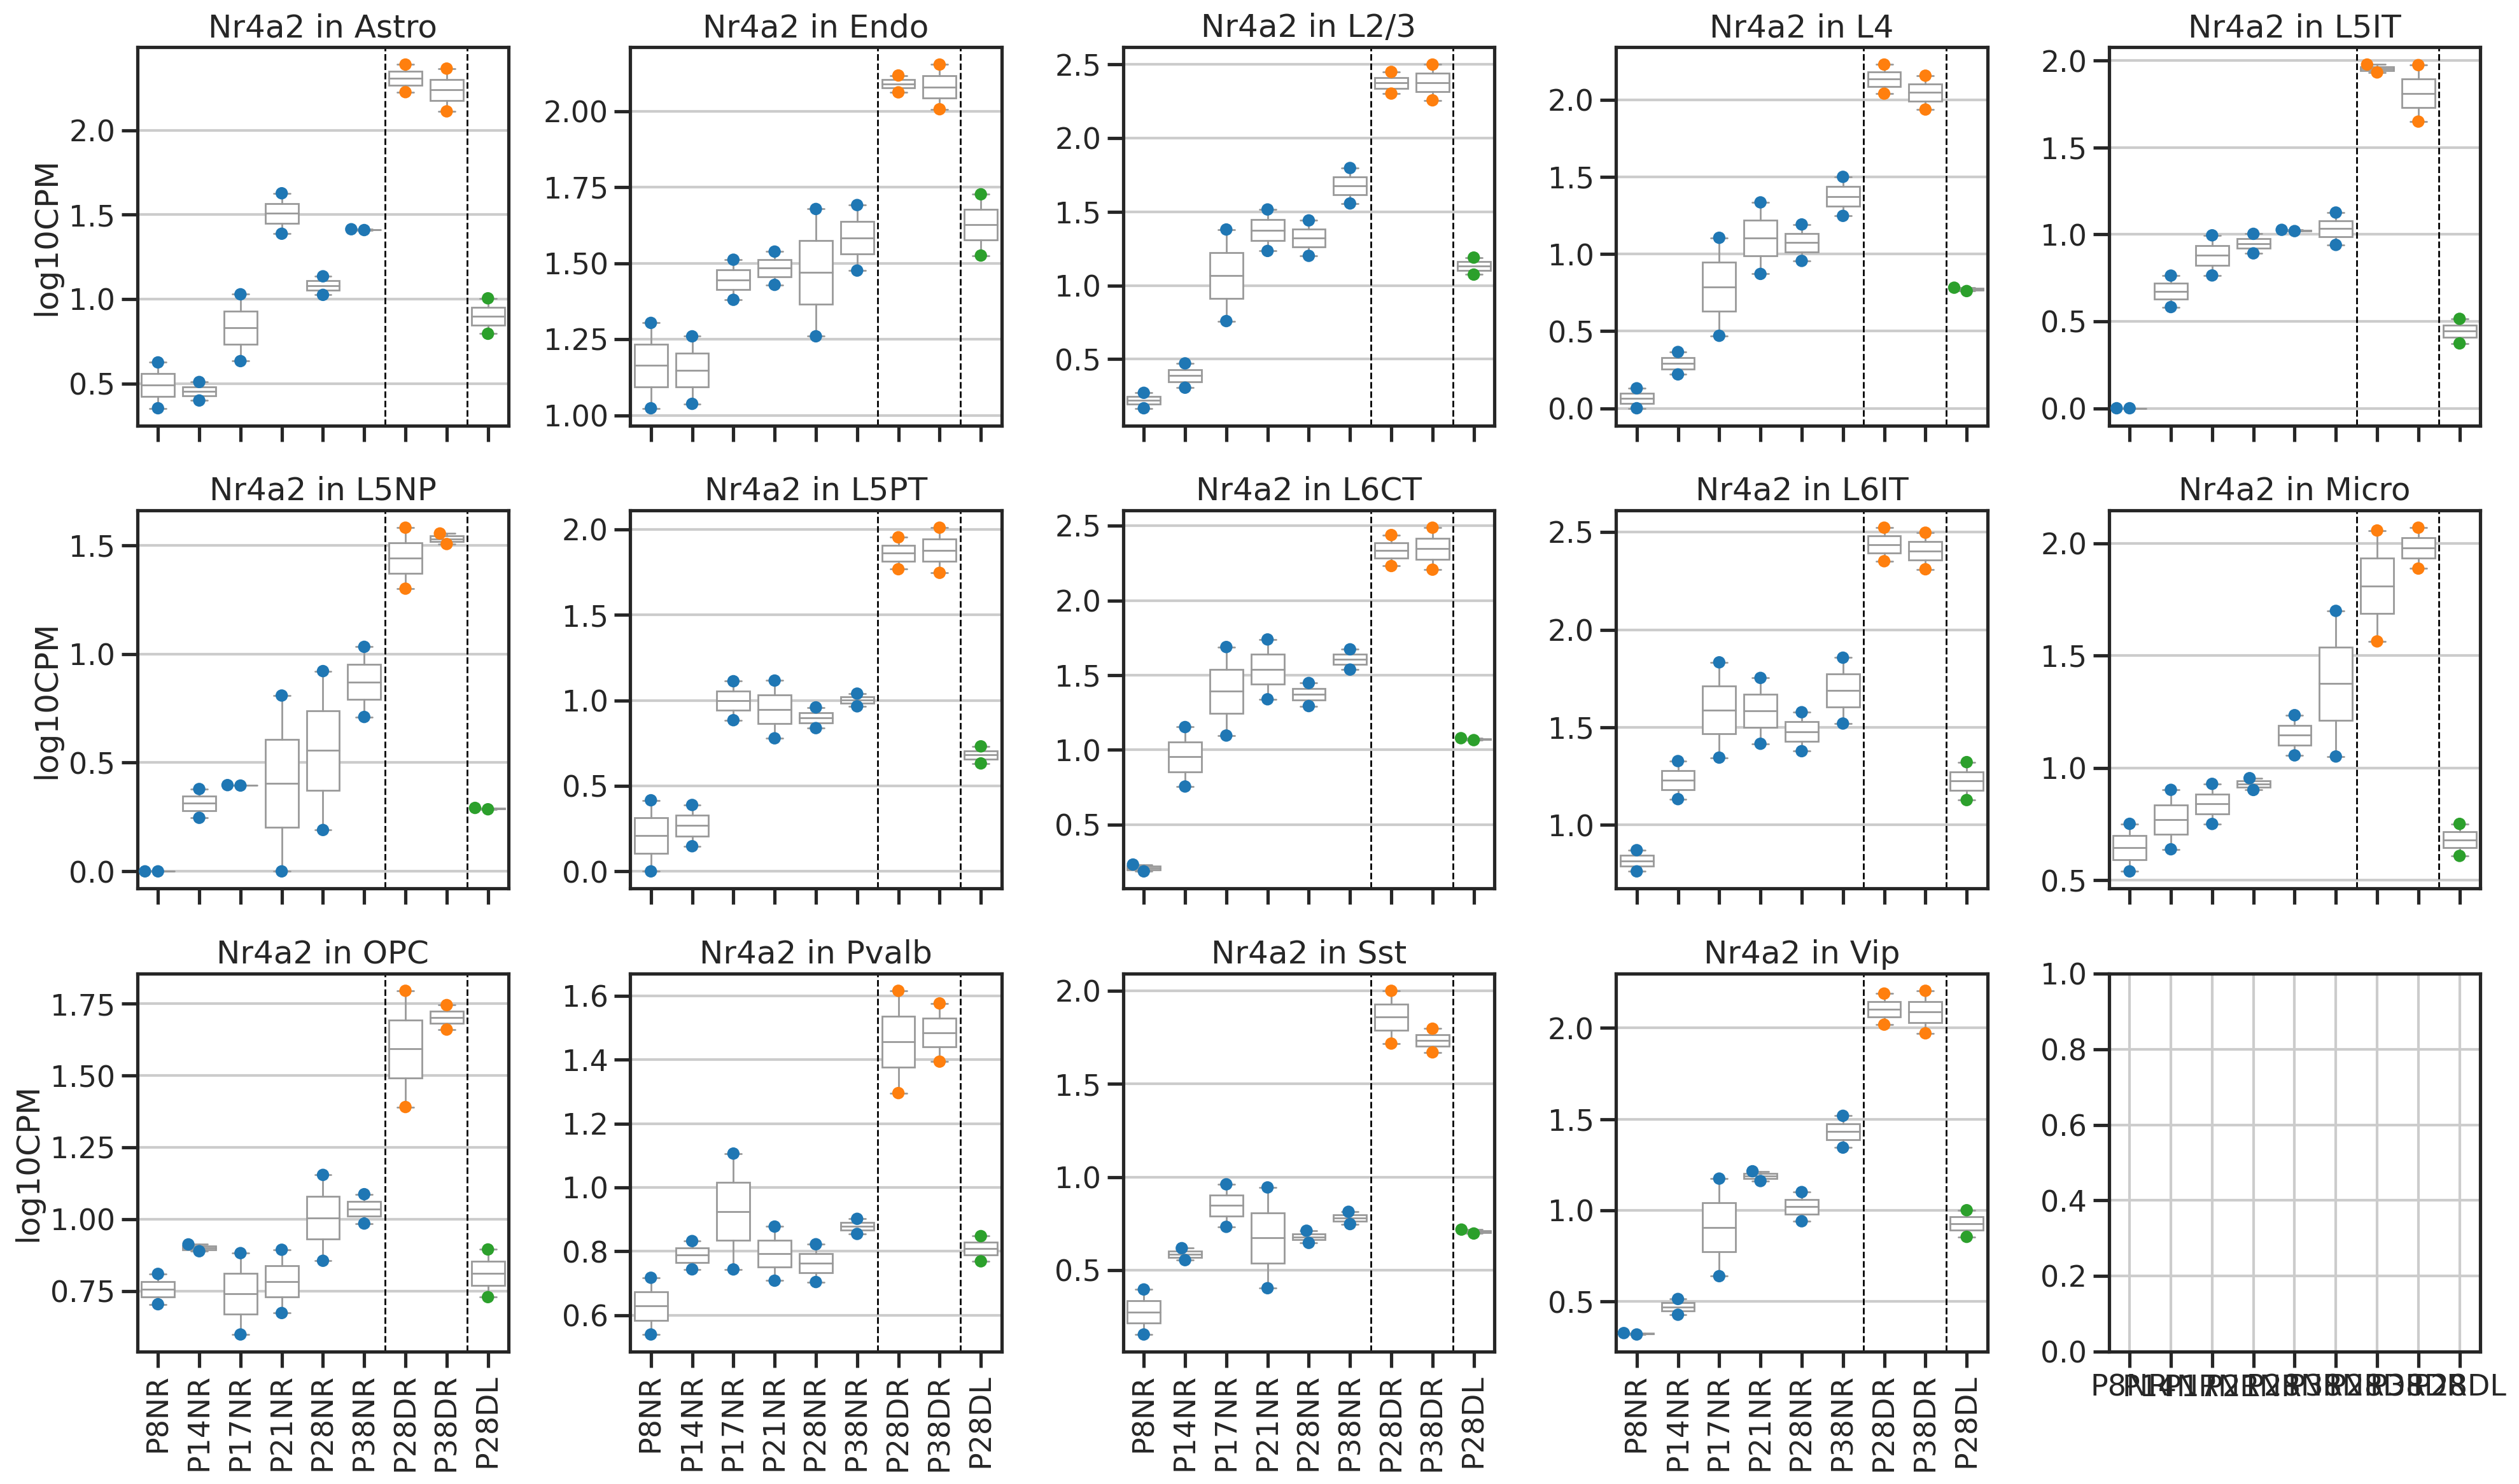

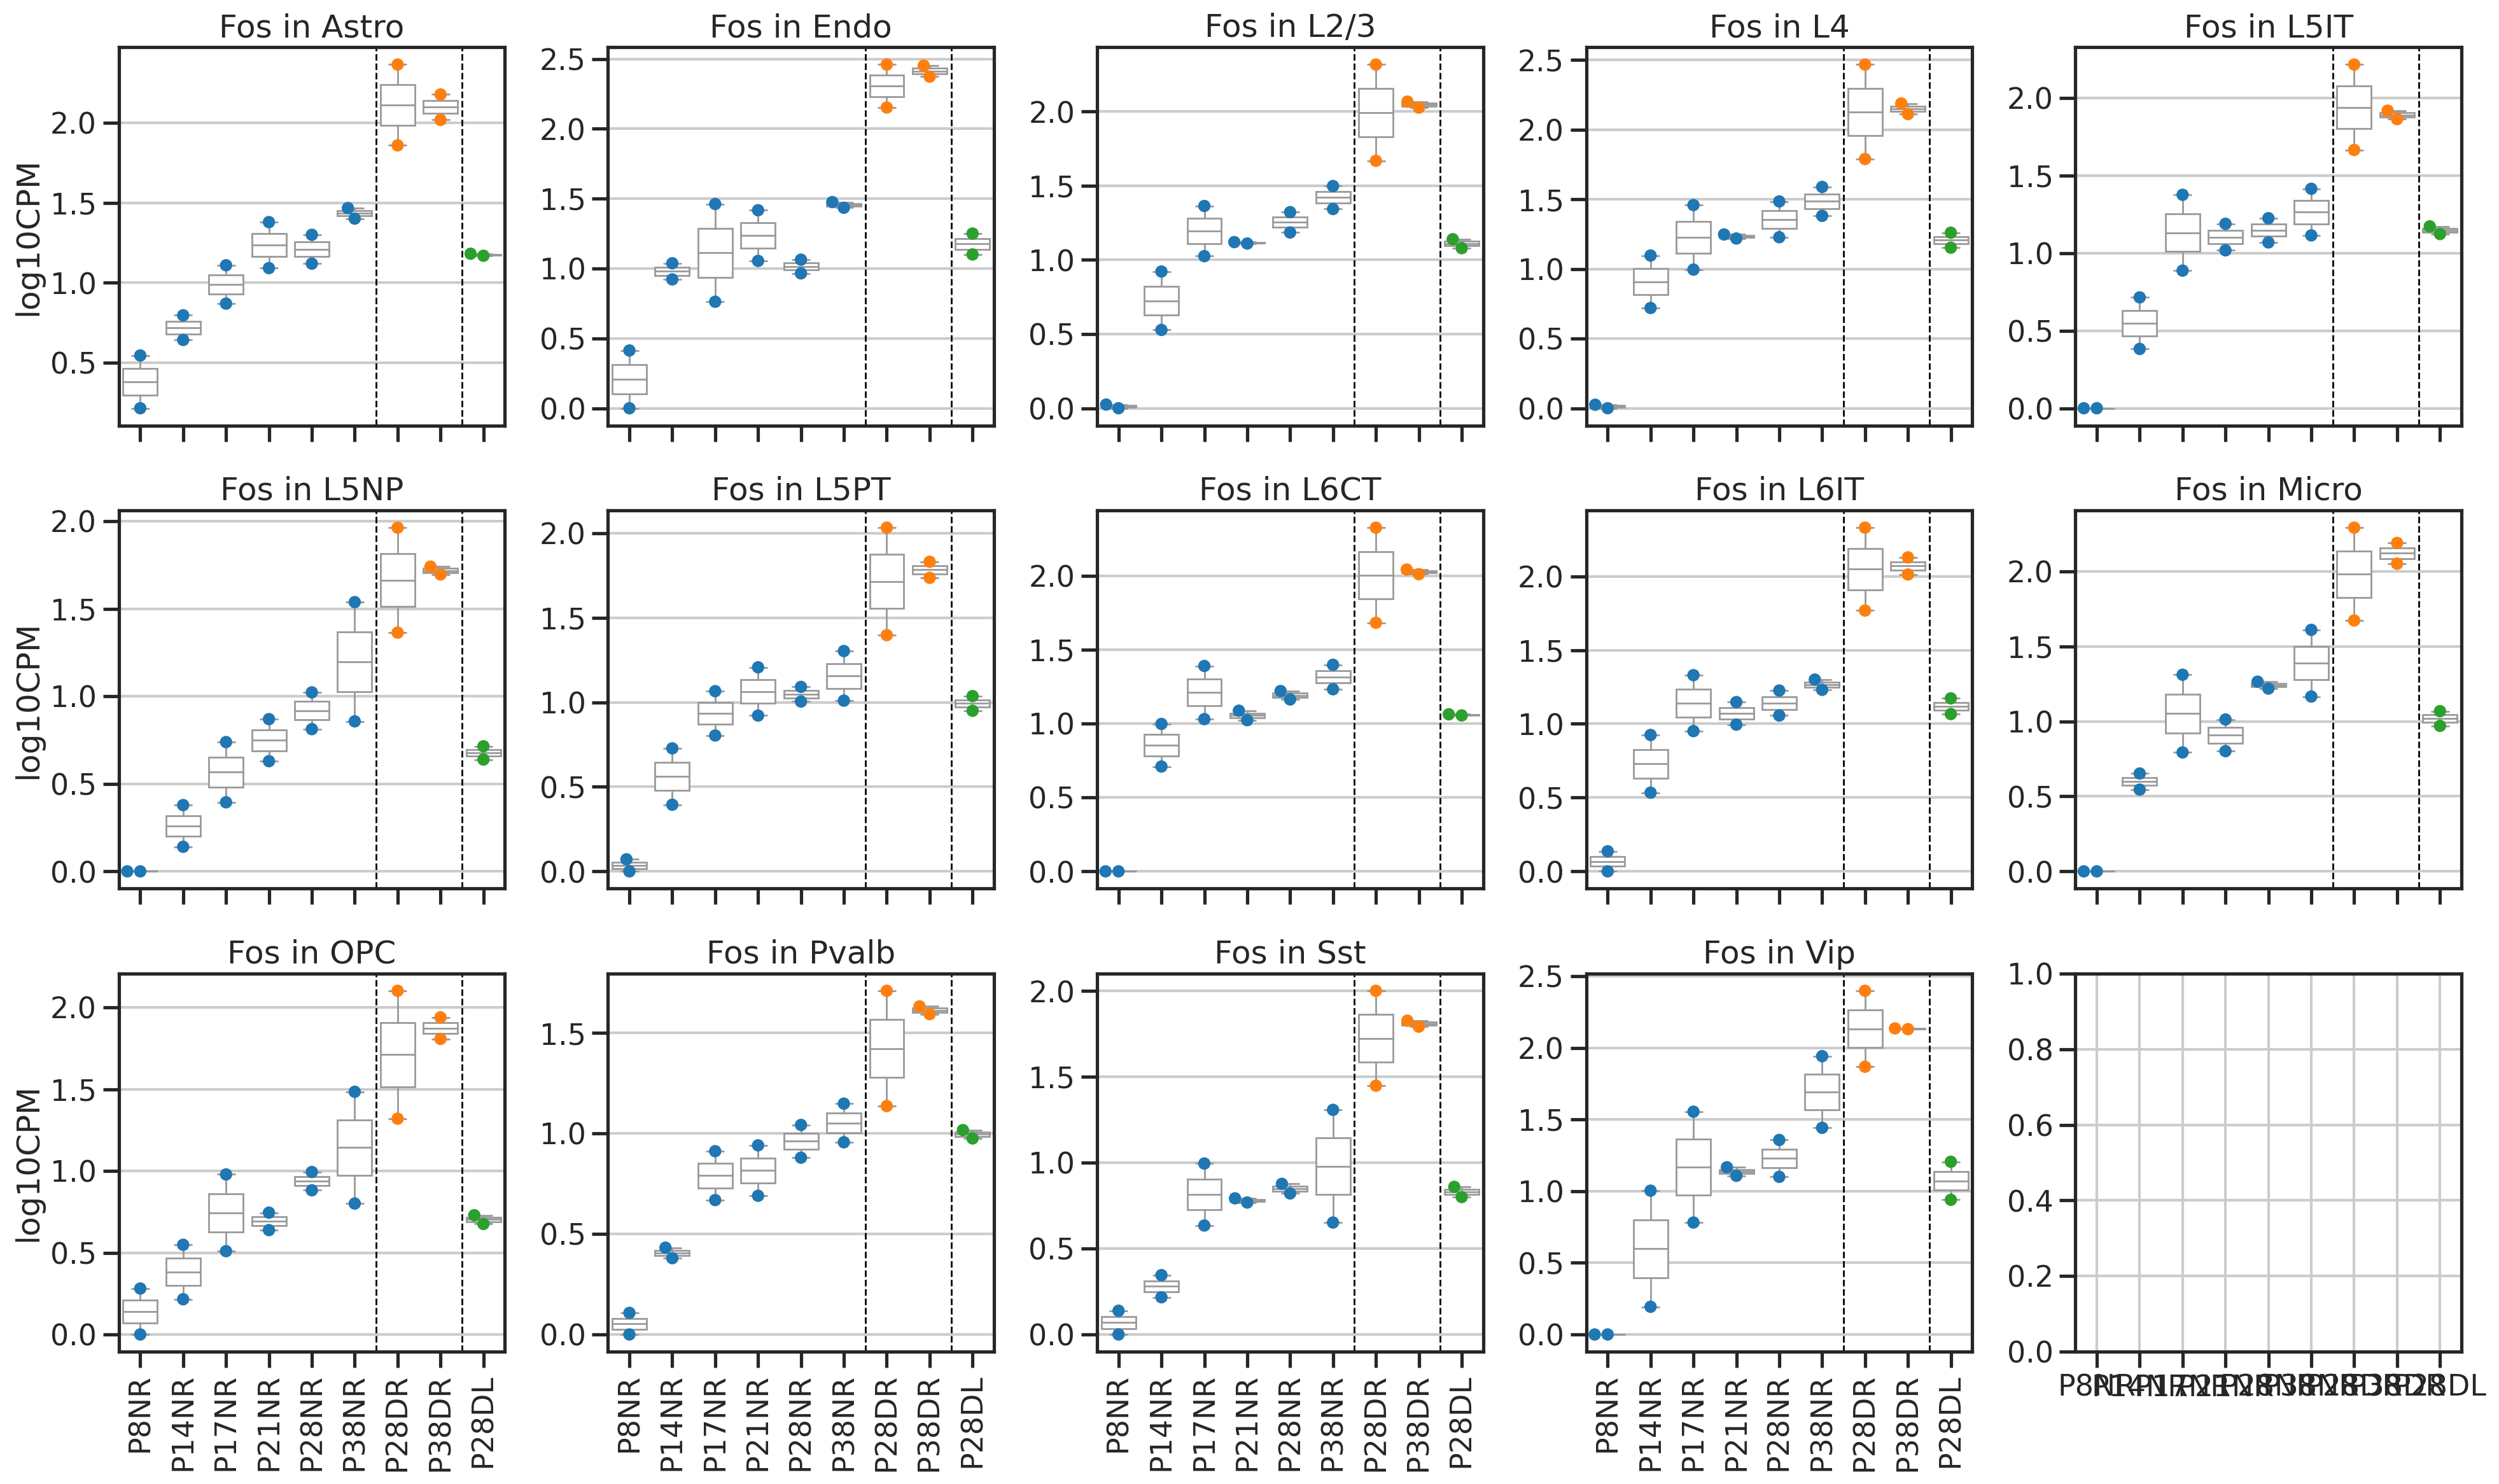

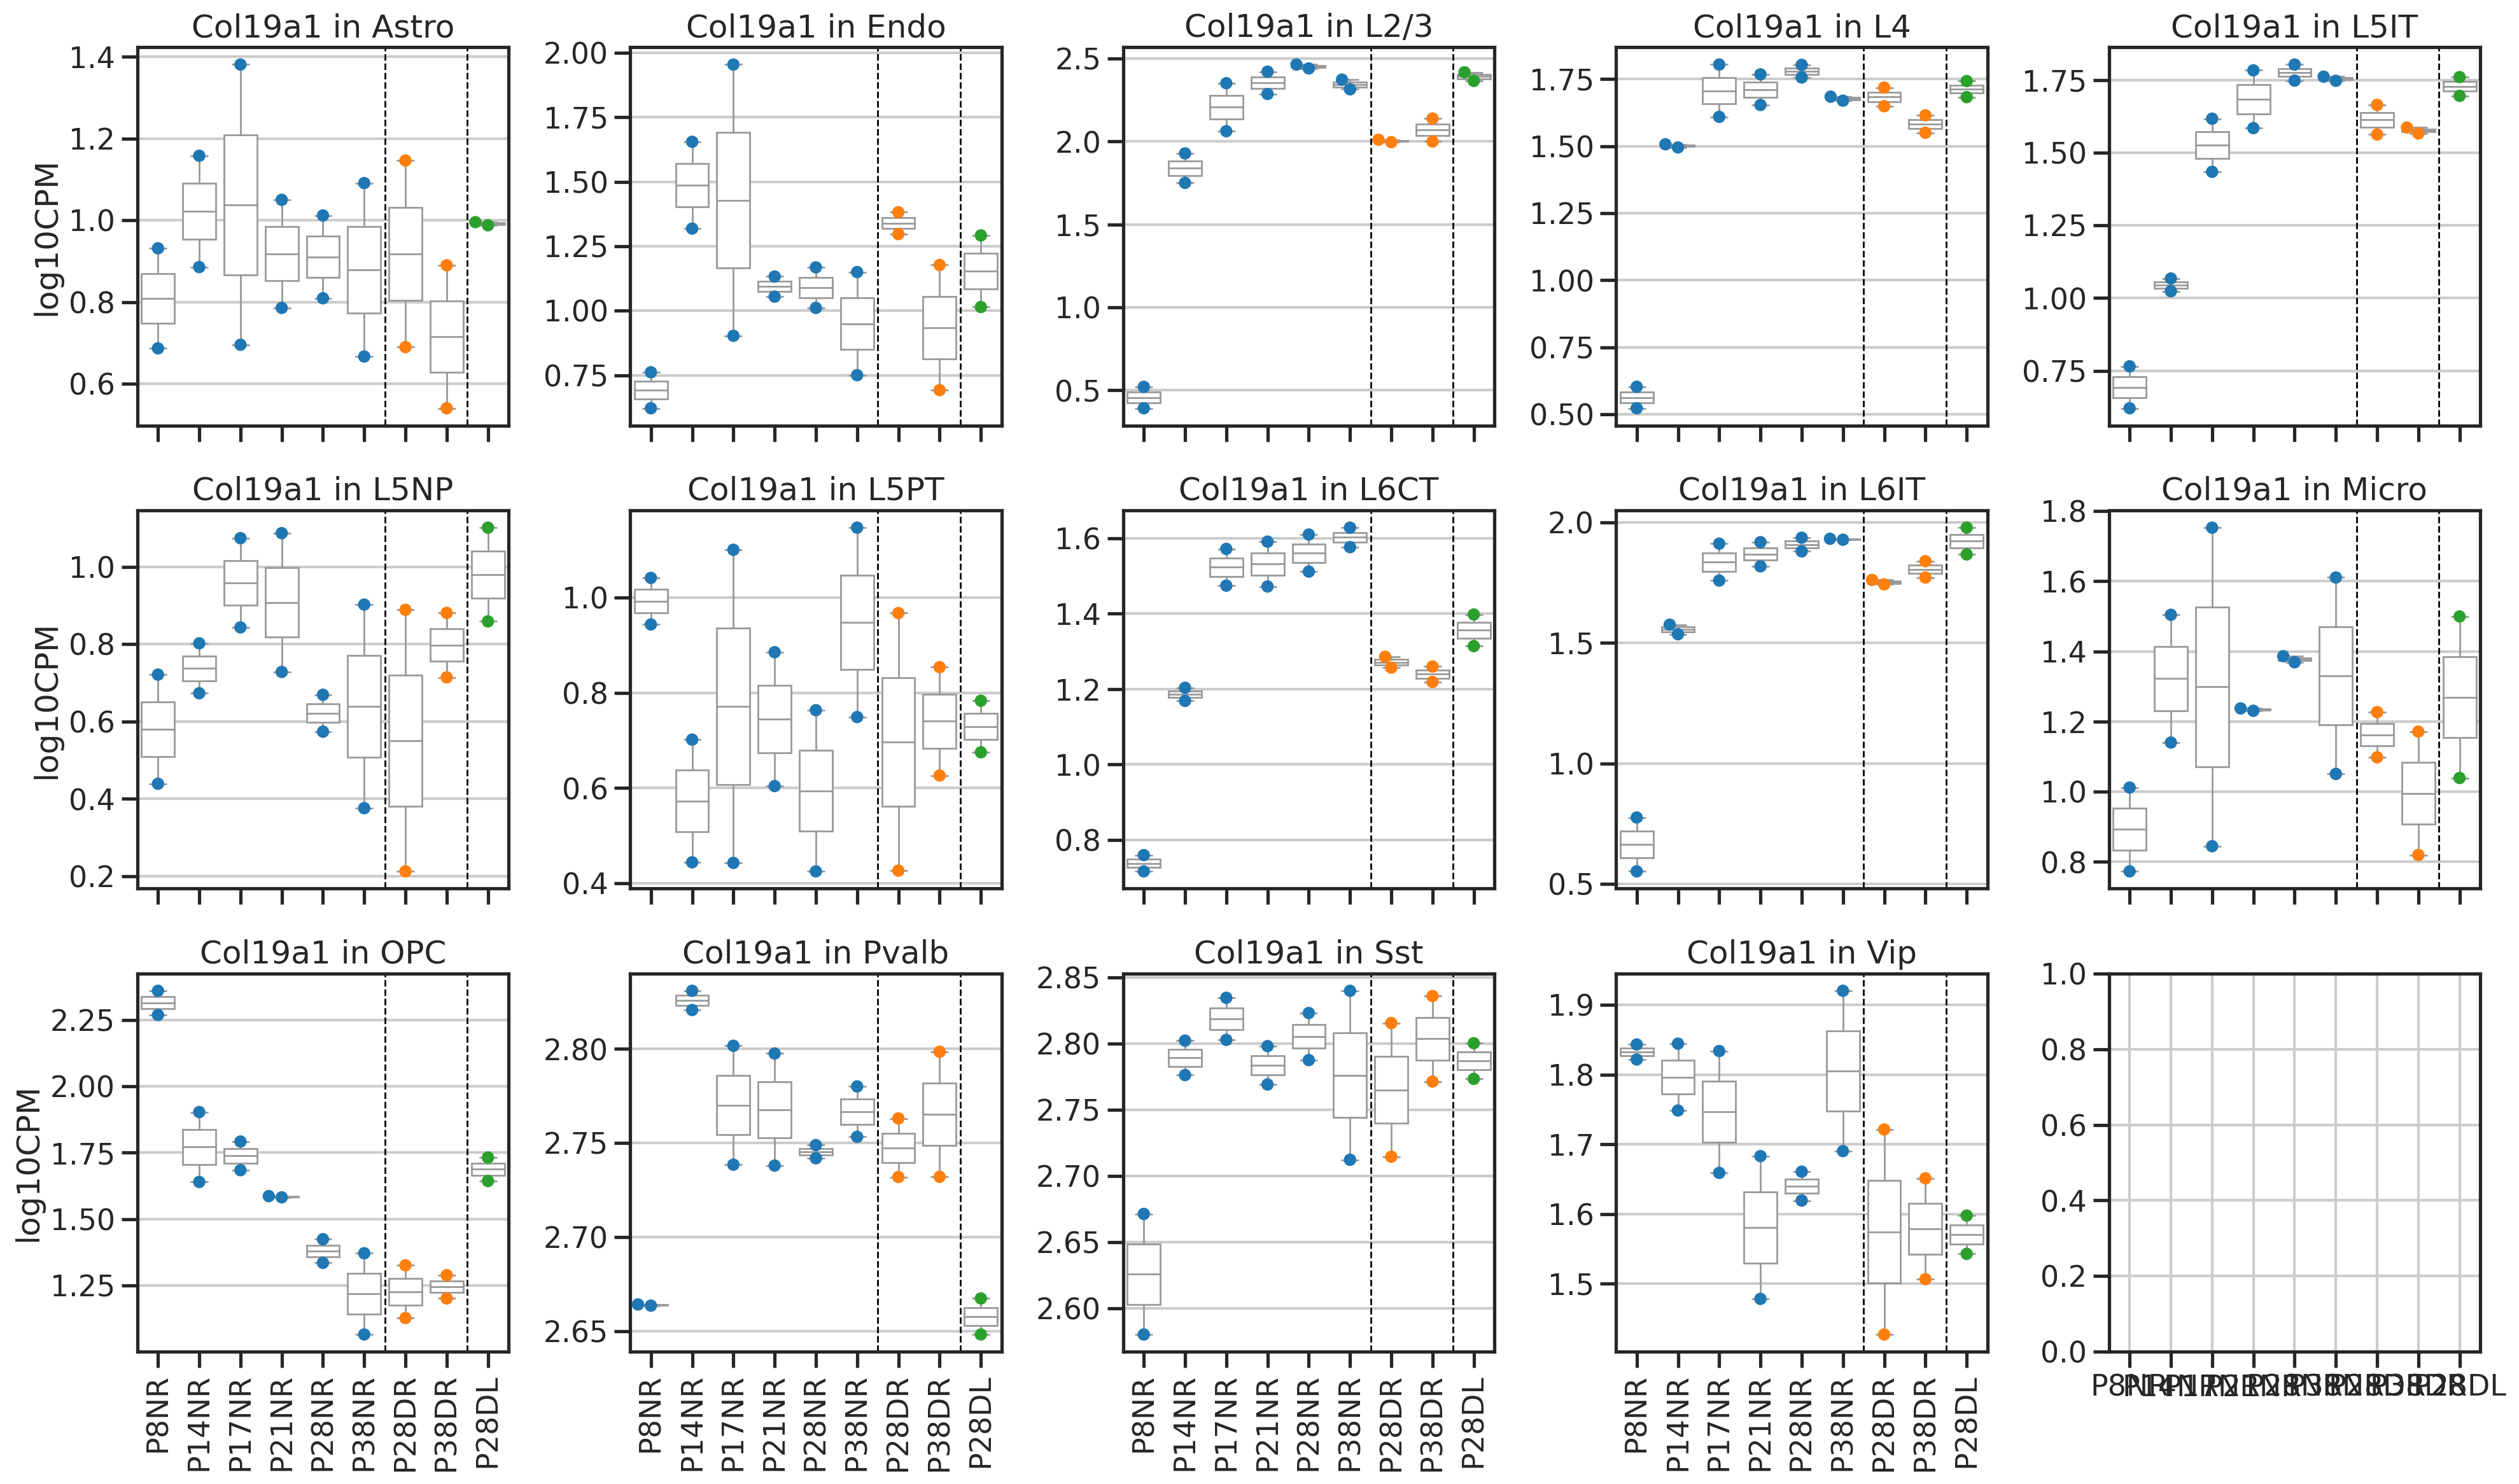

In [14]:
for gene_name in ['Nr4a2', 'Fos', 'Col19a1']:
    fig, axs = plt.subplots(3,5,figsize=(5*4,3*4), sharex=True)
    for i, type_name in enumerate(unq_types):
        ax = axs.flat[i]
        ax = plot_one_gene(gene_name, type_name, ax=ax, conds=conds, palette=palette, s=7)
        if i%5 != 0:
            ax.set_ylabel('')
        ax.axvline(5.5, linestyle='--', color='k', linewidth=1)
        ax.axvline(7.5, linestyle='--', color='k', linewidth=1)
    fig.tight_layout()

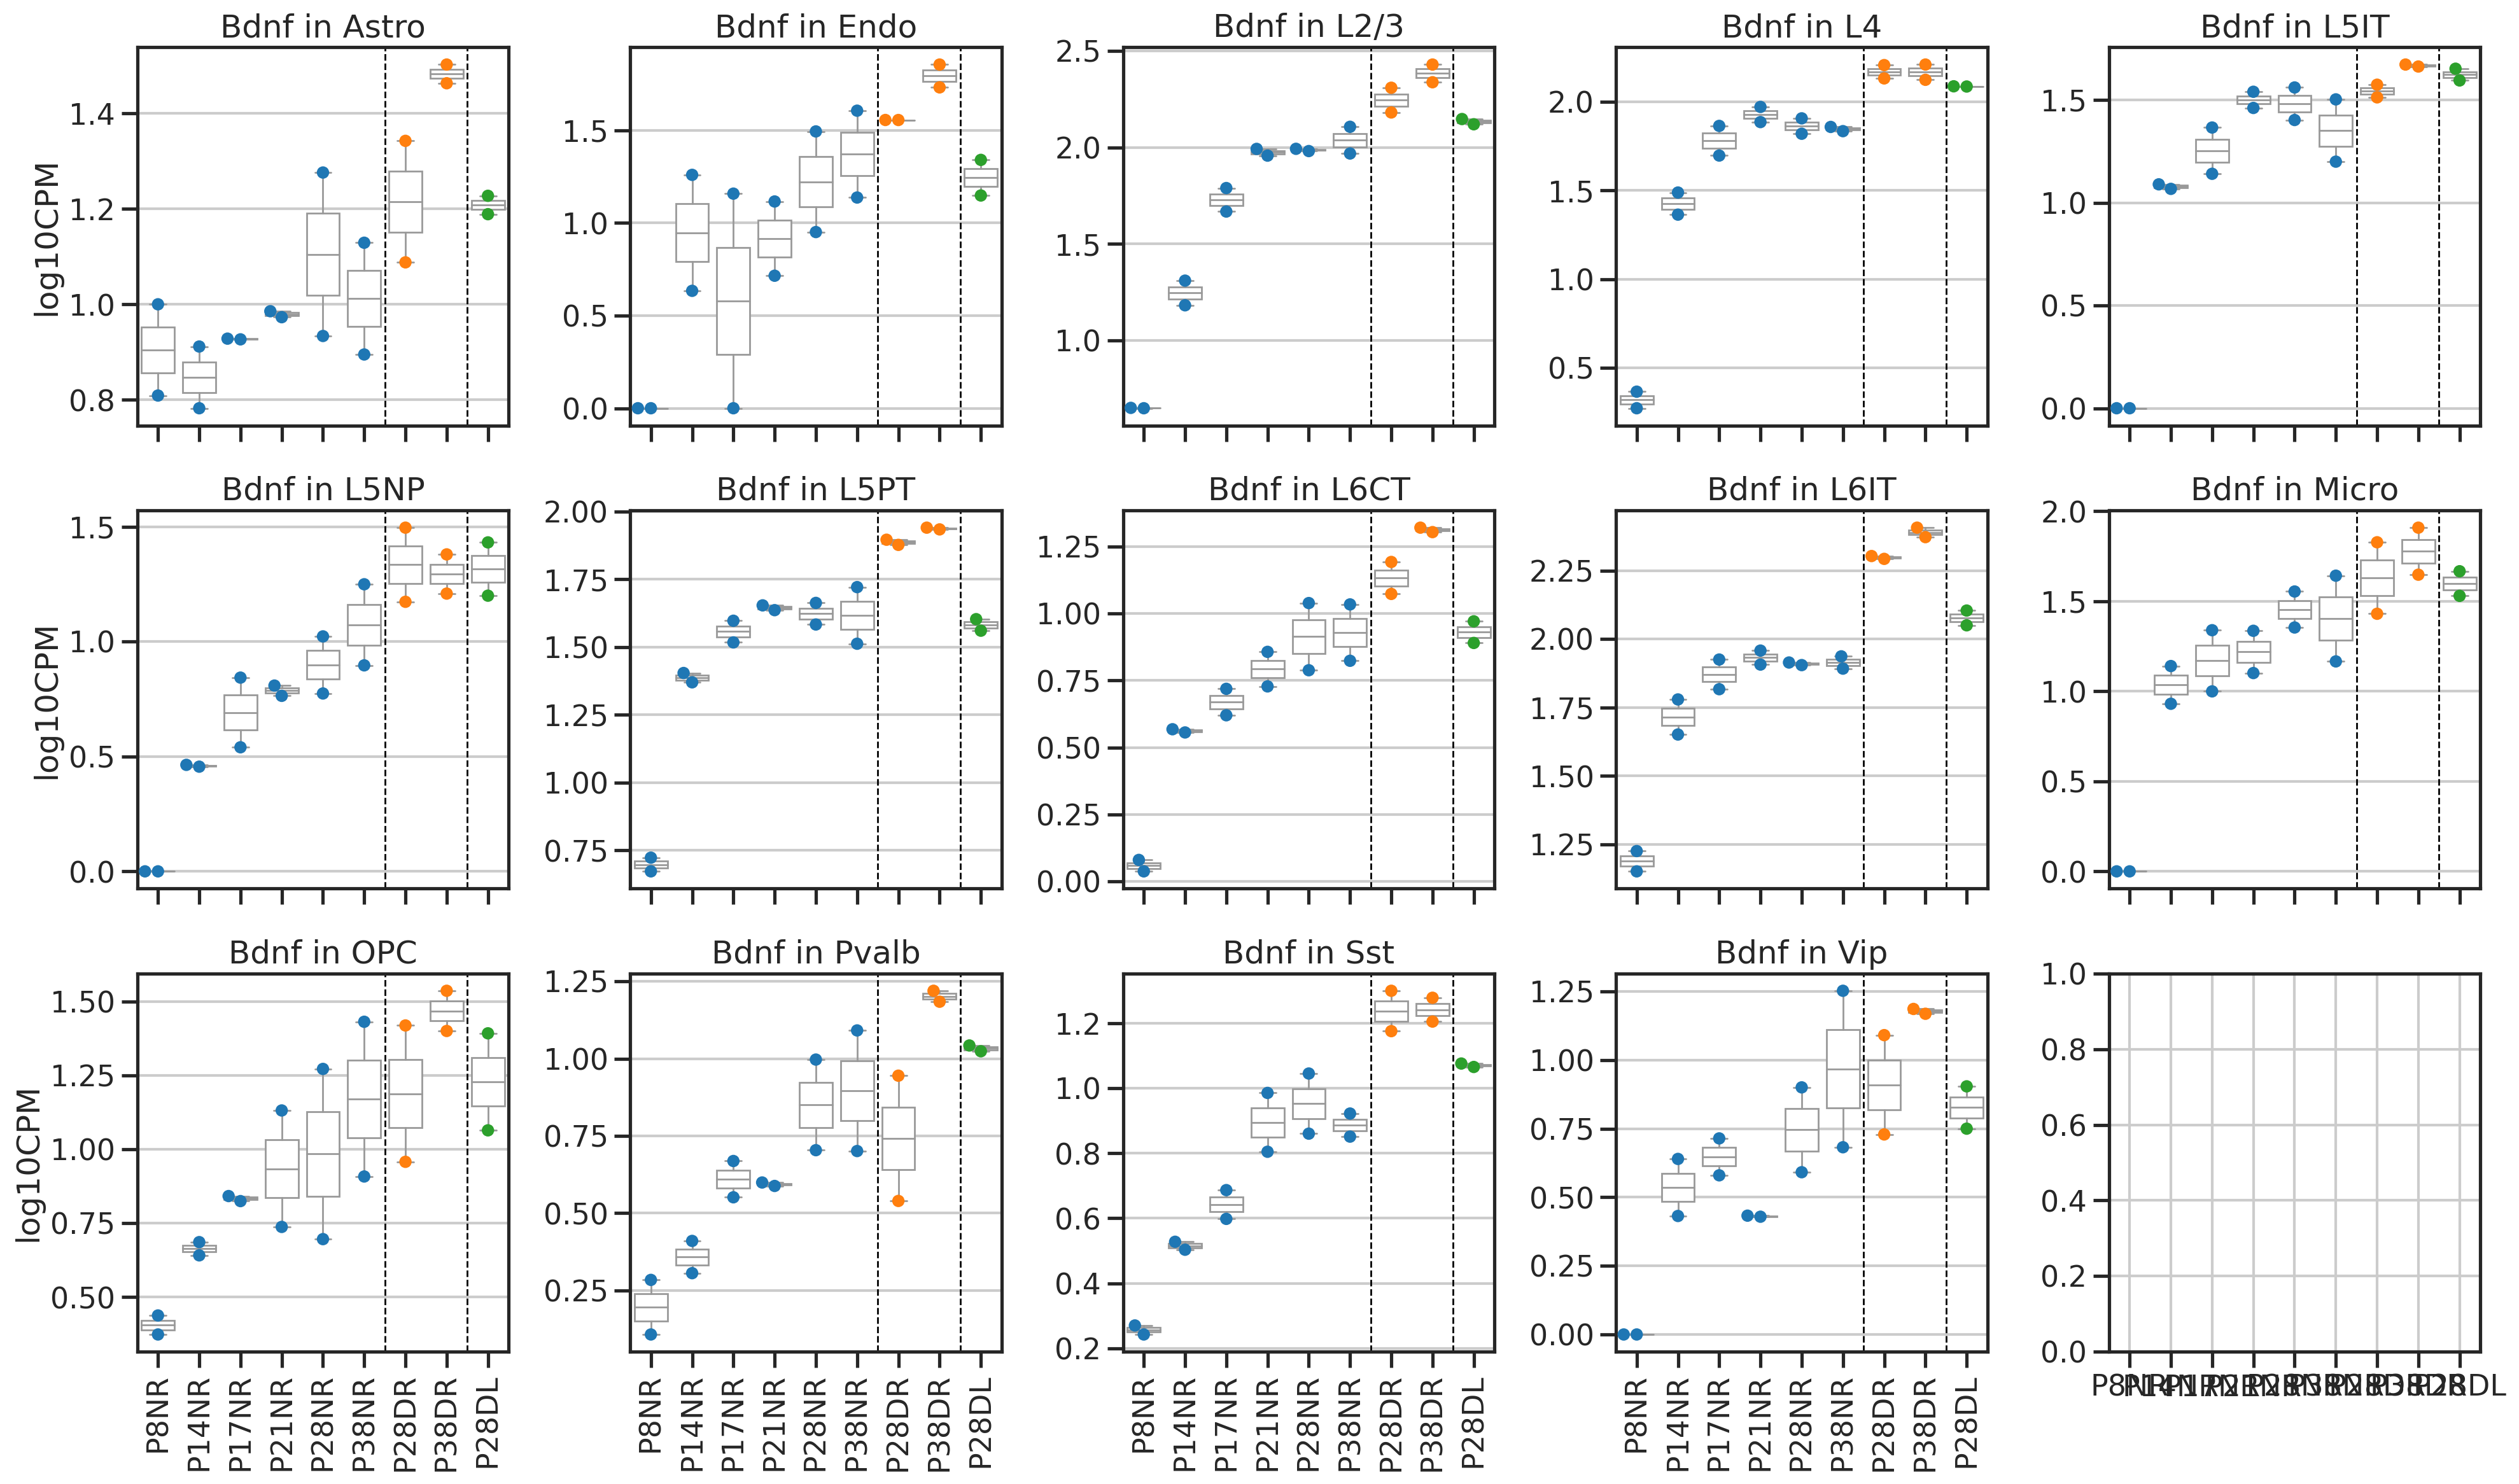

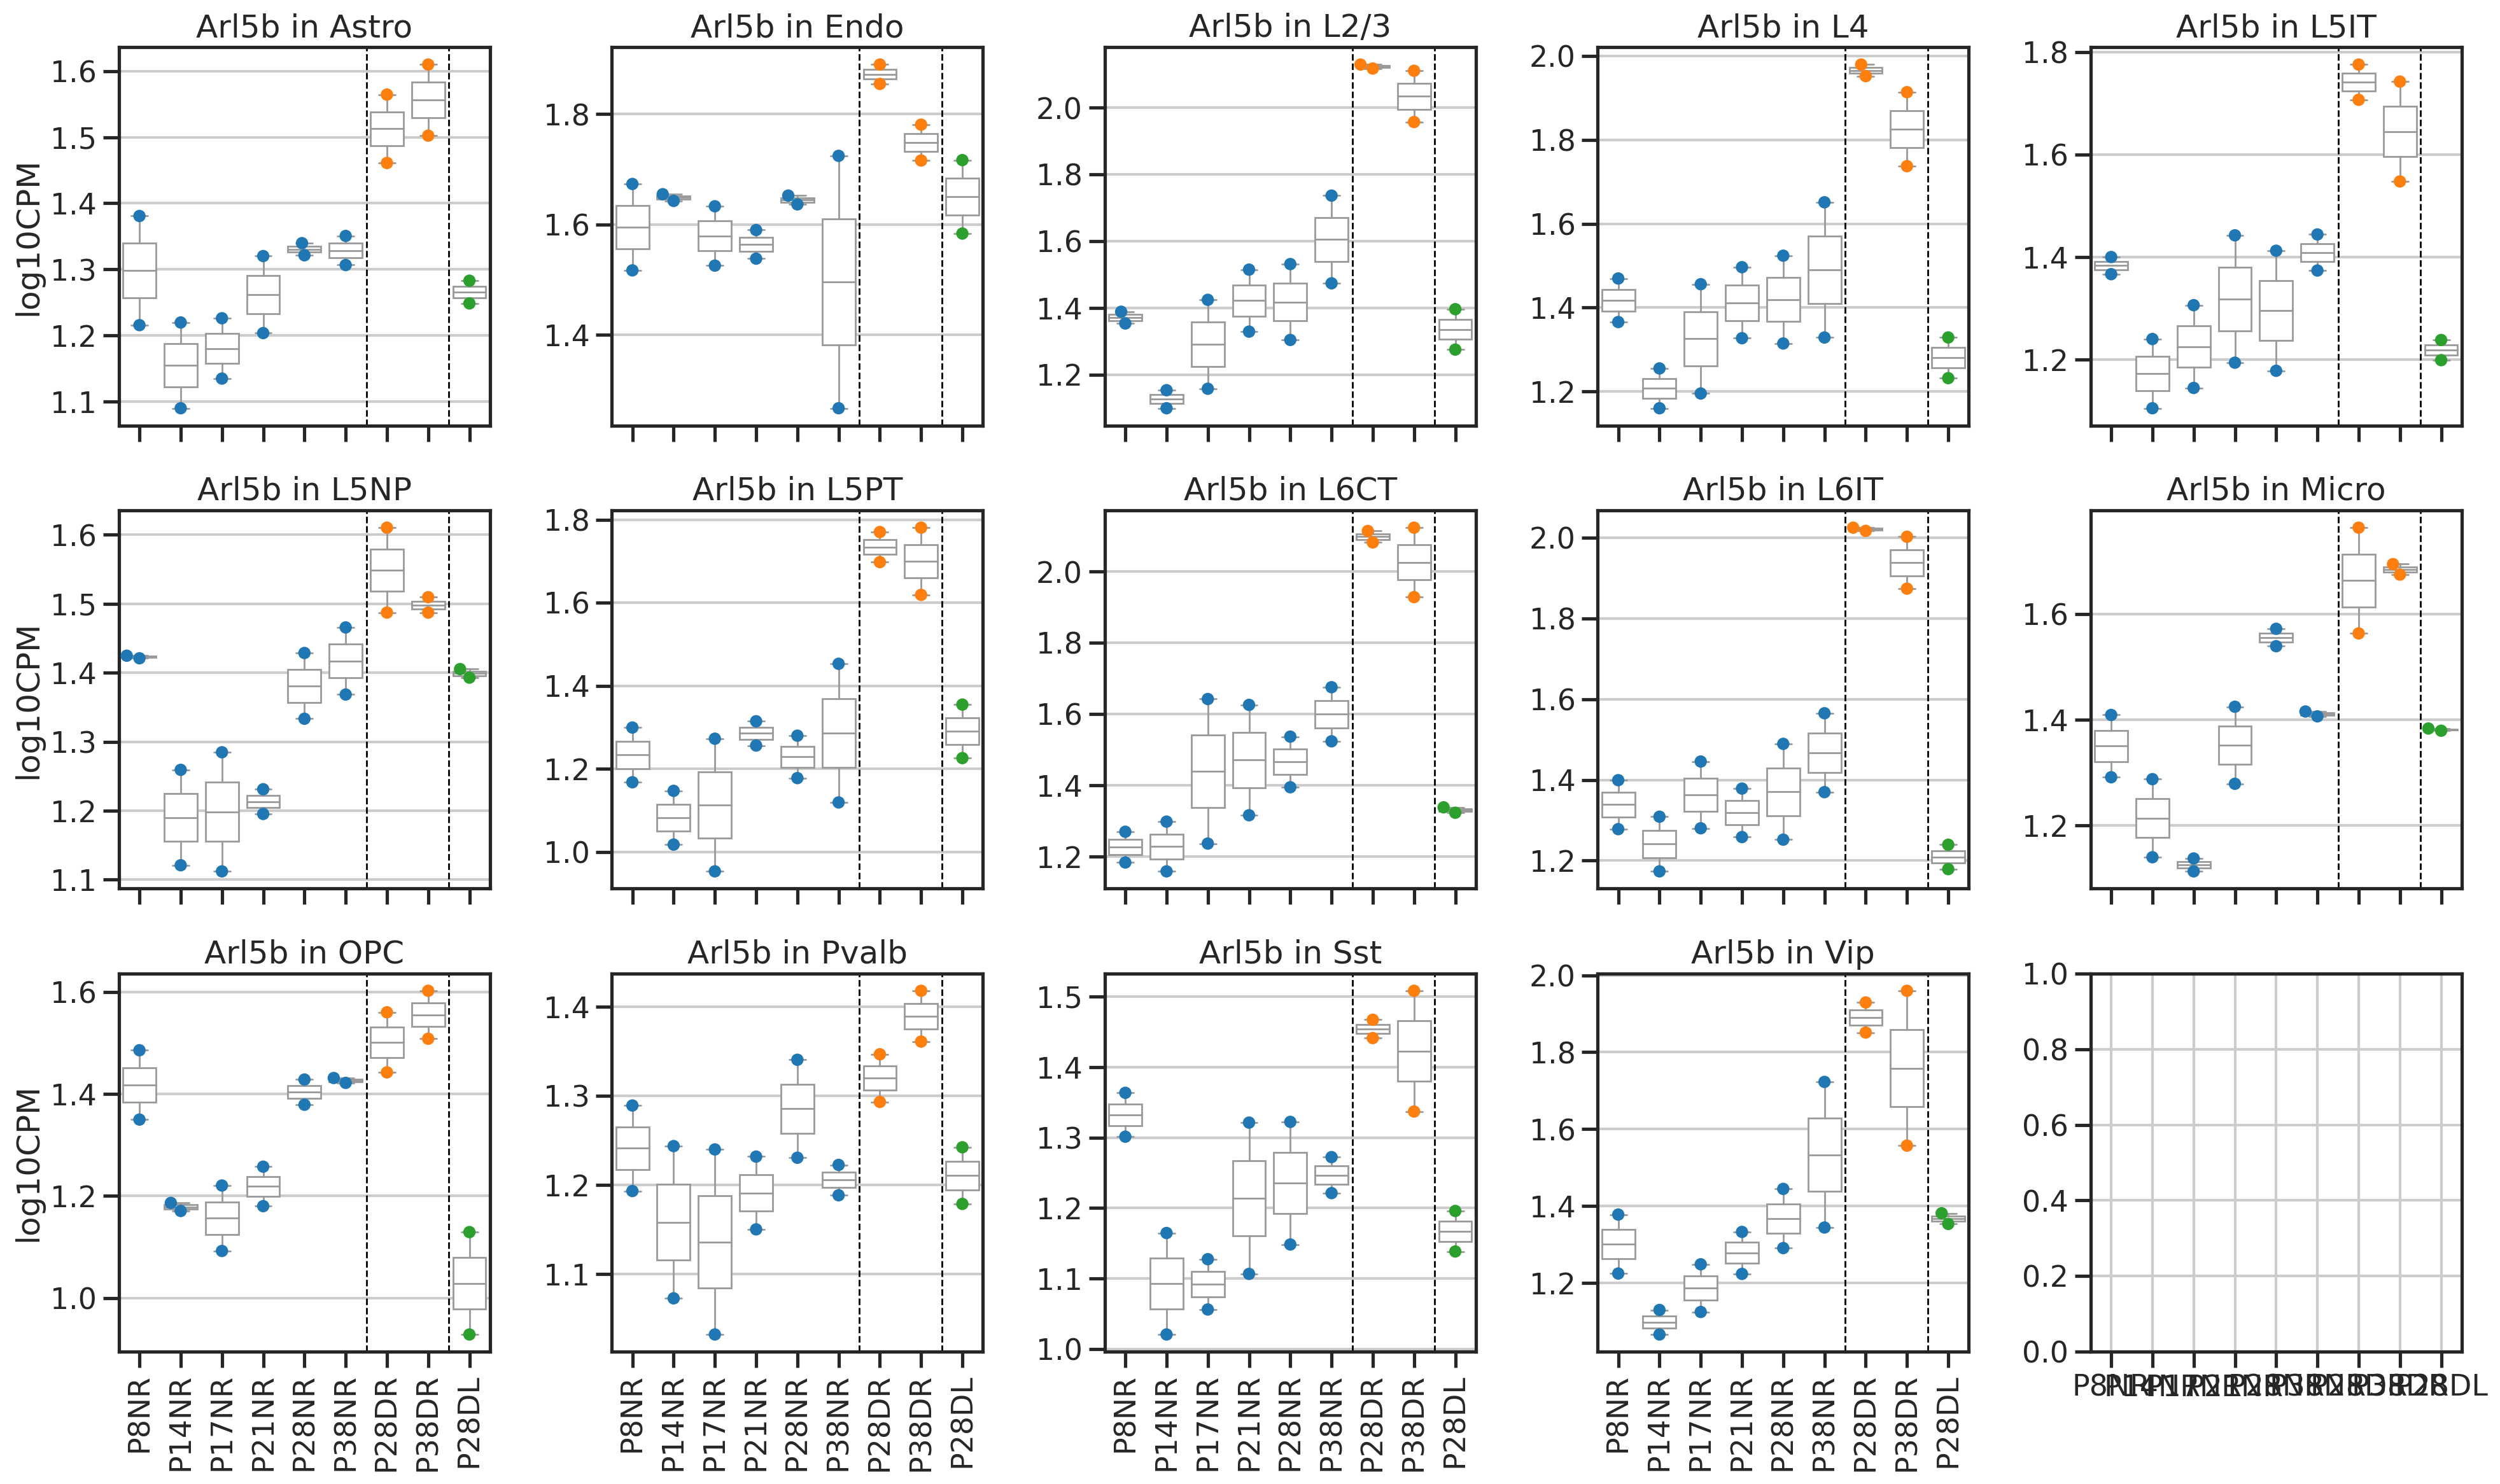

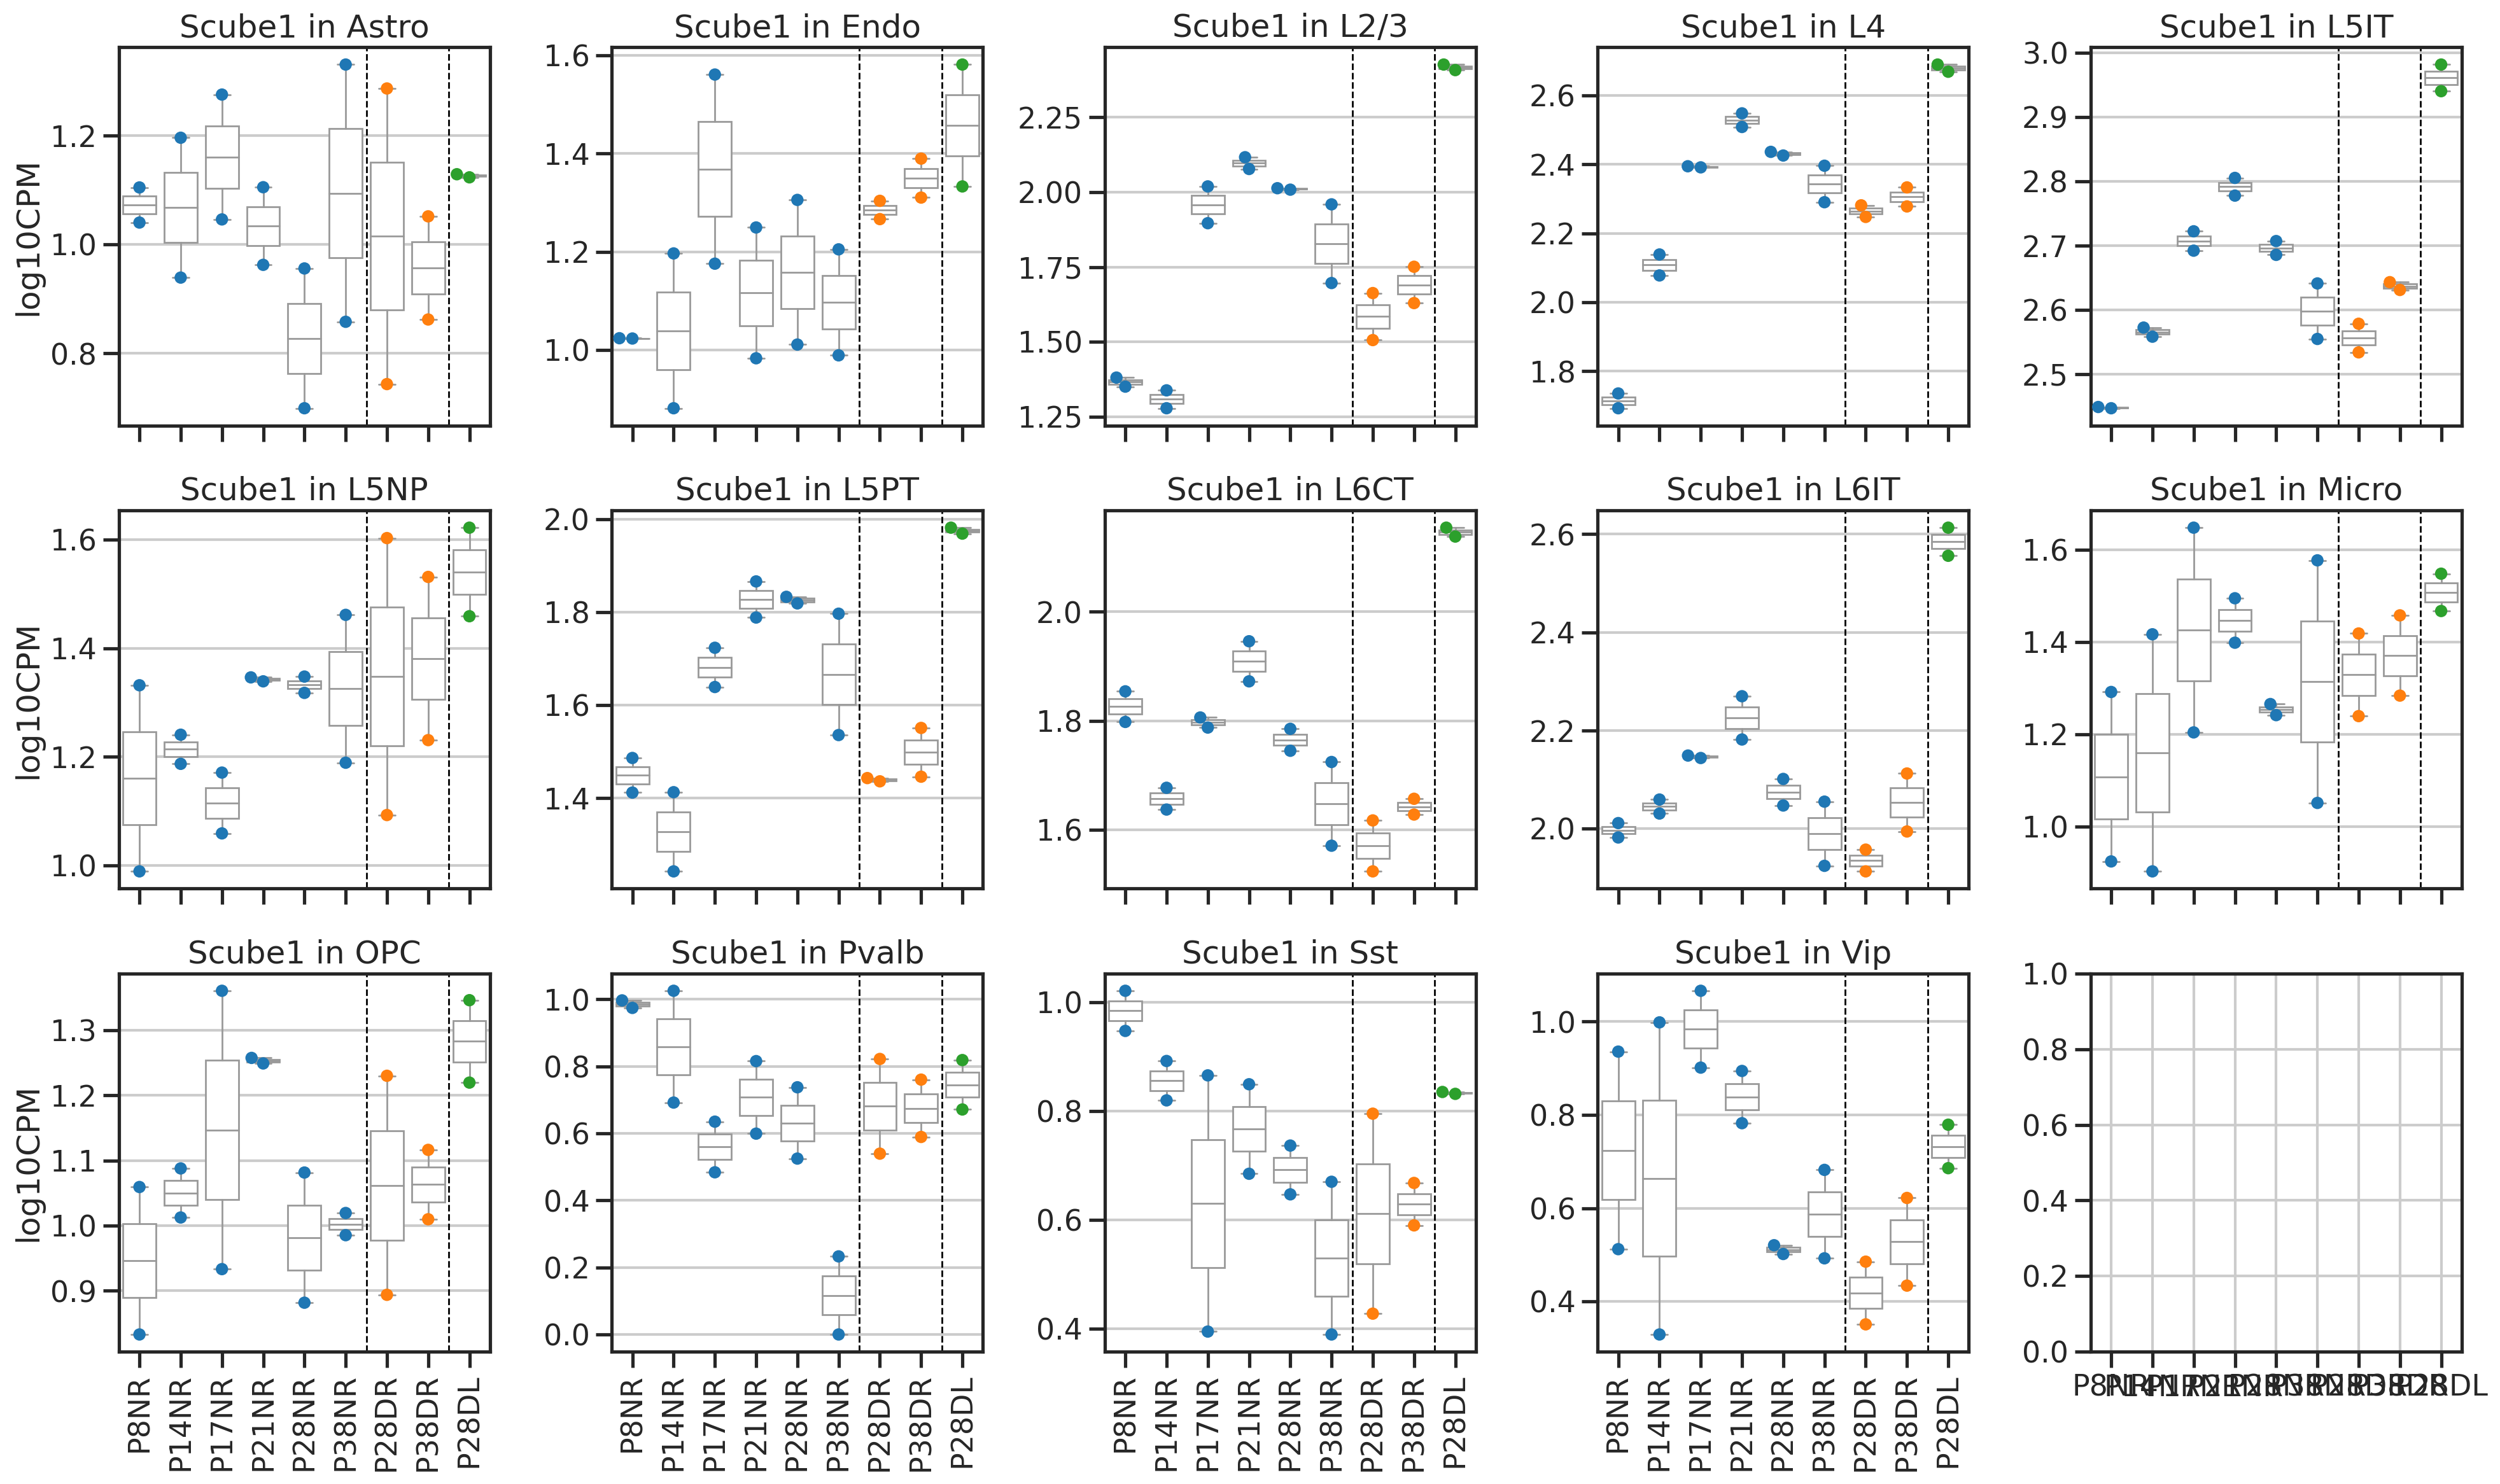

In [15]:
for gene_name in ['Bdnf', 'Arl5b', 'Scube1']:
    fig, axs = plt.subplots(3,5,figsize=(5*4,3*4), sharex=True)
    for i, type_name in enumerate(unq_types):
        ax = axs.flat[i]
        ax = plot_one_gene(gene_name, type_name, ax=ax, conds=conds, palette=palette, s=7)
        if i%5 != 0:
            ax.set_ylabel('')
        ax.axvline(5.5, linestyle='--', color='k', linewidth=1)
        ax.axvline(7.5, linestyle='--', color='k', linewidth=1)
    fig.tight_layout()

([<matplotlib.axis.XTick at 0x7f97da2a6760>,
 [Text(8, 0, '8'),
  Text(14, 0, '14'),
  Text(17, 0, '17'),
  Text(21, 0, '21'),
  Text(28, 0, '28'),
  Text(38, 0, '38')])

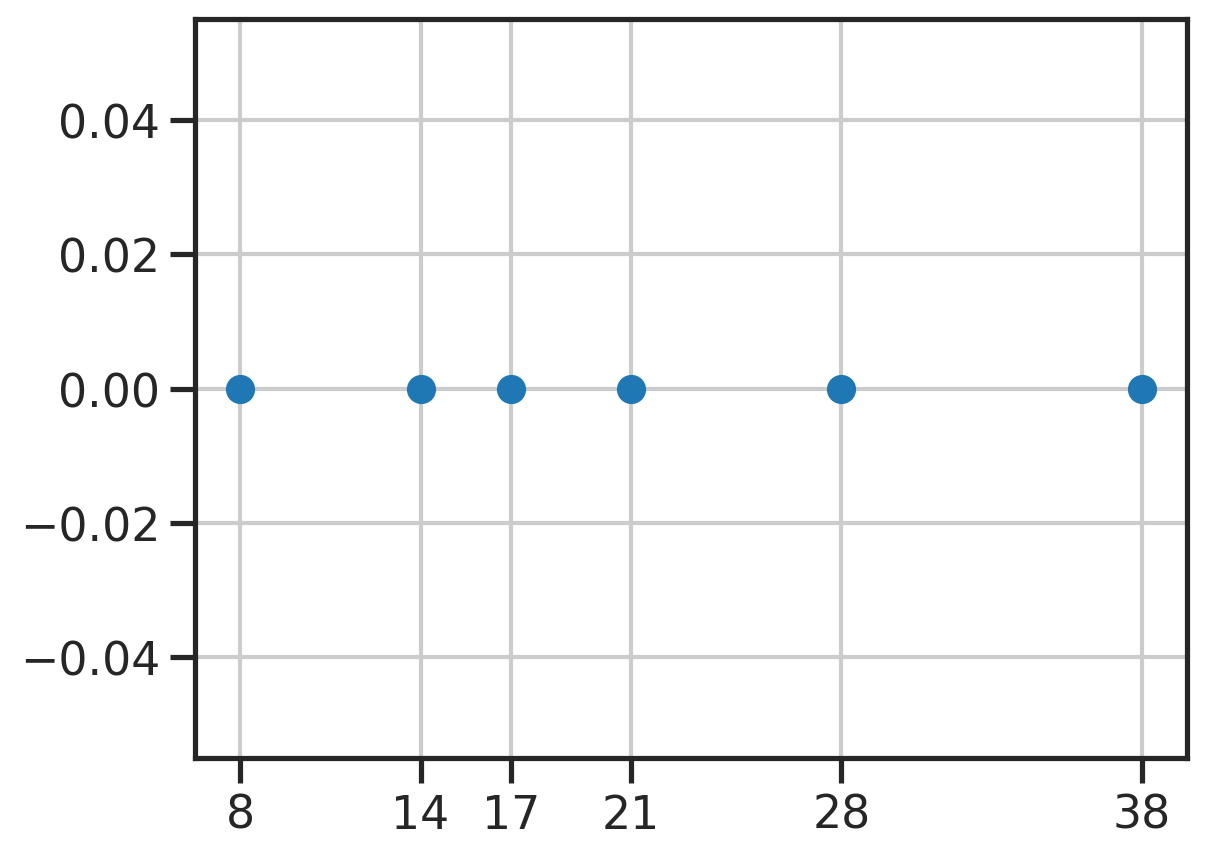

In [18]:
plt.scatter([8,14,17,21,28,38], [0]*6)
plt.xticks([8,14,17,21,28,38])